## pix2pix pytorch lightning

### Data loader

In [5]:
%matplotlib inline
import os
import sys
from PIL import Image
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [6]:
import os
import torchvision
from argparse import ArgumentParser, Namespace
from collections import OrderedDict

In [7]:
from models.pix2pix.datasets import ImageDataset, FloorplanDataset

import albumentations as A
import torchvision.transforms as transforms

In [8]:
dataset_name = "floor/newyork"
img_height = 256
img_width = 256

In [8]:
# transforms_ = [
#     transforms.Resize((img_height, img_width), Image.BICUBIC),
#     transforms.ToTensor(),
# #             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ]

In [9]:
transforms_ = [
            A.RandomResizedCrop(
                img_height,
                img_width,
            ),
            A.Rotate(23),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(),
            A.HueSaturationValue(),
            A.RGBShift(),
            A.RandomGamma(),
            # A.CLAHE(),
#             MyCoarseDropout(
#                 min_holes=1,
#                 max_holes=8,
#                 max_height=32,
#                 max_width=32,
#             ),
            # A.Resize(img_size, img_size, interpolation=cv2.INTER_CUBIC),
#             A.Normalize(
#                 mean=[0.485, 0.456, 0.406],
#                 std=[0.229, 0.224, 0.225],
#             ),
            # ToTensorV2(),
        ]

In [10]:
dataset = FloorplanDataset("./datasets/%s" % dataset_name, transforms_=transforms_, mode="test")

In [11]:
len(dataset)

53

In [12]:
def draw(A, B):    
    fig = plt.figure(figsize=(10, 10))

    plt.subplot(1, 2, 1)
    plt.imshow(A)
    plt.title('original')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(B)
    plt.title('mask')
    plt.axis('off')
    plt.show()

In [13]:
dataset.files[12]

'./datasets/floor/newyork/test/45719584.jpg'

In [11]:
for i in range(len(dataset)):
    item = dataset[i]
    print(item['A'].shape, item['B'].shape)
    break

(3, 256, 256) (3, 256, 256)


In [12]:
item['A'].shape, item['B'].shape

((3, 256, 256), (3, 256, 256))

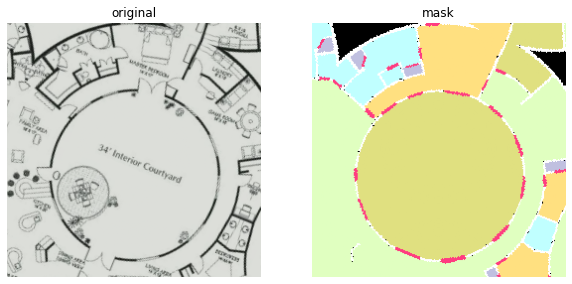

In [13]:
draw(item['A'].transpose((1, 2, 0)), item['B'].transpose((1, 2, 0)))

### Train

In [1]:
from pytorch_lightning.trainer import Trainer
from models.pix2pix_model import Pix2PixModel
from torchsummary import summary
import torch
from pytorch_lightning.loggers import TensorBoardLogger
from pathlib import Path
from time import time

#### Model Summary

In [2]:
model = Pix2PixModel()

In [3]:
train_loader = model.train_dataloader()

In [5]:
for batch in train_loader:
    print(batch['A'].shape)
    print(batch['B'].shape)
    break

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model.to(device)
summary(model, input_size=(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,072
         LeakyReLU-2         [-1, 64, 128, 128]               0
          UNetDown-3         [-1, 64, 128, 128]               0
            Conv2d-4          [-1, 128, 64, 64]         131,072
    InstanceNorm2d-5          [-1, 128, 64, 64]               0
         LeakyReLU-6          [-1, 128, 64, 64]               0
          UNetDown-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 256, 32, 32]         524,288
    InstanceNorm2d-9          [-1, 256, 32, 32]               0
        LeakyReLU-10          [-1, 256, 32, 32]               0
         UNetDown-11          [-1, 256, 32, 32]               0
           Conv2d-12          [-1, 512, 16, 16]       2,097,152
   InstanceNorm2d-13          [-1, 512, 16, 16]               0
        LeakyReLU-14          [-1, 512,

#### Model Training

In [2]:
tb_logger = TensorBoardLogger(
        f'logs',
        name=f'pix2pix_floorplan',
        version=str(int(time())),
    )
log_dir = Path(tb_logger.log_dir)
log_dir.mkdir(parents=True, exist_ok=True)

In [3]:
model = Pix2PixModel(batch_size=2, dataset_name="floor/newyork")

In [4]:
trainer = Trainer(logger=tb_logger, weights_save_path=f'experiments', gpus=[0], max_epochs=100)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type          | Params
------------------------------------------------------
0 | generator           | GeneratorUNet | 54 M  
1 | discriminator       | Discriminator | 2 M   
2 | criterion_GAN       | MSELoss       | 0     
3 | criterion_pixelwise | L1Loss        | 0     
/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)
/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:25: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in t

/home/nghia/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

## Evaluate

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
model = model.to(device)

In [147]:
item = dataset[2]

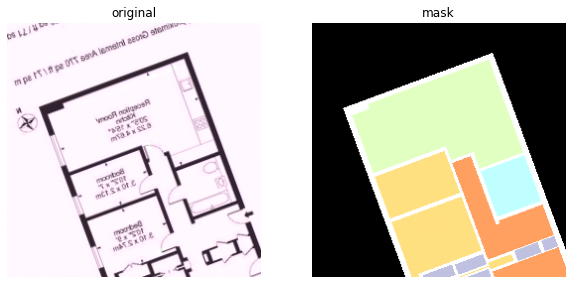

In [148]:
draw(item['A'].transpose((1, 2, 0)), item['B'].transpose((1, 2, 0)))

In [149]:
inp = torch.from_numpy(item['A']).unsqueeze(0)
inp = inp.to(device)

In [150]:
generated = model(inp)

In [151]:
aa = generated.squeeze().cpu().numpy()

In [152]:
aa.transpose((1, 2, 0)).shape, item['B'].transpose((1, 2, 0)).shape

((256, 256, 3), (256, 256, 3))

In [155]:
img_sample = torch.cat((item['A'], item['B'], generated.squeeze()), -2)
grid = torchvision.utils.make_grid(img_sample)

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


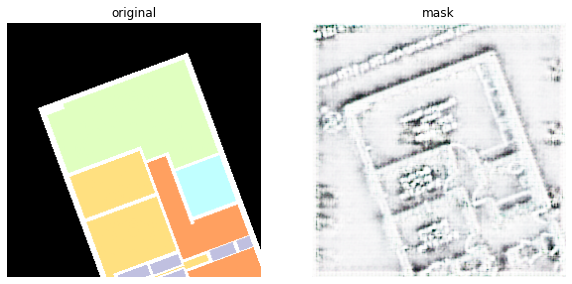

In [153]:
draw(item['B'].transpose((1, 2, 0)), aa.transpose((1, 2, 0)))